<a href="https://colab.research.google.com/github/exseul/2020BigData/blob/master/Leeyeseul_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lee Yeseul 개인 프로젝트_2

신경 스타일 전송은 콘텐츠 이미지와 스타일 참조 이미지 (예 : 유명한 화가의 아트 워크)의 두 이미지를 가져 와서 출력 이미지가 콘텐츠 이미지처럼 보이지만 "페인트"되도록 혼합하는 데 사용되는 최적화 기술입니다. (스타일 참조 이미지 스타일)

이는 콘텐츠 이미지의 콘텐츠 통계 및 스타일 참조 이미지의 스타일 통계와 일치하도록 출력 이미지를 최적화하여 구현됩니다. 이러한 통계는 컨볼 루션 네트워크를 사용하여 이미지에서 추출됩니다.

참고 : https://www.tensorflow.org/lite/models/style_transfer/overview

예를 들어 이 고양이와 Wassily Kandinsky의 Composition 7 이미지를 가져와 보겠습니다.


<img src="https://upload.wikimedia.org/wikipedia/commons/b/b6/Felis_catus-cat_on_snow.jpg" width="500px"/>

[cat_on_snow](https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg), from Wikimedia Commons by [Elf](https://en.wikipedia.org/wiki/User:Elf). License [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en)

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


이제 Kandinsky의 스타일로 고양이 그림을 그려봅시다, 이렇게 :  

<img src="https://github.com/exseul/2020BigData/blob/master/P15/stylized-image%20(1).png?raw=true" style="width: 500px;"/>

## 설정


## Import and configure modules
### 모듈 가져 오기 및 구성

In [39]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [40]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [41]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# 이미지를 다운로드하고 스타일 이미지와 콘텐츠 이미지를 선택합니다.

In [42]:
content_path = tf.keras.utils.get_file('cat_on_snow.jpg', 'https://upload.wikimedia.org/wikipedia/commons/b/b6/Felis_catus-cat_on_snow.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')


In [43]:
content_path

'/root/.keras/datasets/cat_on_snow.jpg'


## 입력 시각화

이미지를로드하고 최대 크기를 512 픽셀로 제한하는 함수를 정의합니다.

In [44]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

이미지를 표시하는 간단한 함수를 만듭니다 :

In [45]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

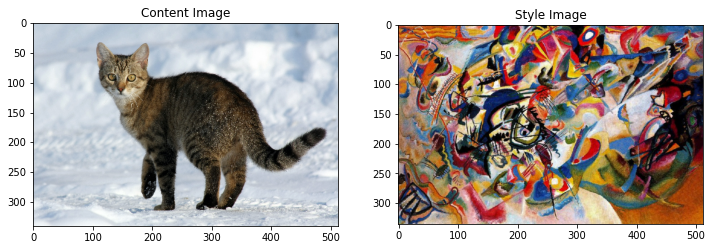

In [46]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## TF-Hub를 사용한 빠른 스타일 전송


이 튜토리얼은 이미지 콘텐츠를 특정 스타일로 최적화하는 원래 스타일 전송 알고리즘을 보여줍니다. 세부 사항에 들어가기 전에 [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) 모델은 다음을 수행합니다.

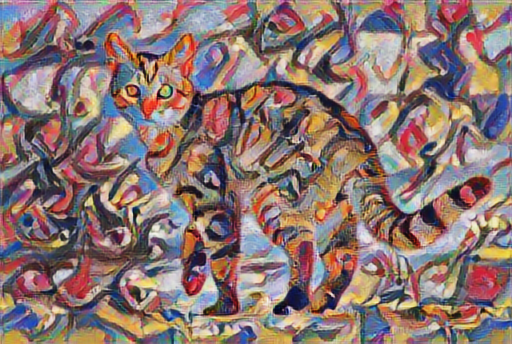

In [47]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)


## 콘텐츠 및 스타일 표현 정의

모델의 중간 레이어를 사용하여 이미지의 *콘텐츠* 및 *스타일* 표현을 가져옵니다. 네트워크의 입력 계층에서 시작하여 처음 몇 개의 계층 활성화는 가장자리 및 텍스처와 같은 저수준 기능을 나타냅니다. 네트워크를 통과 할 때 마지막 몇 개의 레이어는 *바퀴* 나 *눈*과 같은 개체 부분과 같은 더 높은 수준의 기능을 나타냅니다. 이 경우 사전 훈련 된 이미지 분류 네트워크 인 VGG19 네트워크 아키텍처를 사용하고 있습니다. 이러한 중간 레이어는 이미지에서 콘텐츠와 스타일의 표현을 정의하는 데 필요합니다. 입력 이미지의 경우 이러한 중간 레이어에서 해당 스타일 및 콘텐츠 대상 표현을 일치 시키십시오.


[VGG19](https://keras.io/applications/#vgg19) 를 로드하고 이미지에서 테스트 실행하여 올바르게 사용되는지 확인합니다. : 

In [48]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [49]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('coyote', 0.48287168),
 ('timber_wolf', 0.16646543),
 ('red_fox', 0.10455199),
 ('lynx', 0.09768114),
 ('grey_fox', 0.04927447)]

이제 분류 헤드없이 VGG19를로드하고 레이어 이름을 나열합니다.

In [50]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


네트워크에서 중간 레이어를 선택하여 이미지의 스타일과 콘텐츠를 나타냅니다.

In [51]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### 스타일과 콘텐츠를위한 중간 레이어

그렇다면 사전 훈련 된 이미지 분류 네트워크 내에서 이러한 중간 출력을 통해 스타일 및 콘텐츠 표현을 정의 할 수있는 이유는 무엇입니까?

높은 수준에서 네트워크가 이미지 분류 (이 네트워크가 수행하도록 훈련 됨)를 수행하려면 이미지를 이해해야합니다. 이를 위해서는 원시 이미지를 입력 픽셀로 가져와 원시 이미지 픽셀을 이미지 내에 존재하는 특징에 대한 복잡한 이해로 변환하는 내부 표현을 구축해야합니다.

이는 컨볼 루션 신경망이 잘 일반화 할 수있는 이유이기도합니다. 배경 잡음 및 기타 성가신 것에 대해 무관 한 클래스 (예 : 고양이 대 개) 내에서 불변성을 포착하고 특징을 정의 할 수 있습니다. 따라서 원시 이미지가 모델에 공급되는 위치와 출력 분류 레이블 사이 어딘가에서 모델은 복잡한 특징 추출기 역할을합니다. 모델의 중간 레이어에 액세스하여 입력 이미지의 내용과 스타일을 설명 할 수 있습니다.

## 모델 구축

`tf.keras.applications`의 네트워크는 Keras 기능 API를 사용하여 중간 계층 값을 쉽게 추출 할 수 있도록 설계되었습니다.

기능 API를 사용하여 모델을 정의하려면 입력 및 출력을 지정하십시오.

`model = Model(inputs, outputs)`

다음 함수는 중간 레이어 출력 목록을 반환하는 VGG19 모델을 빌드합니다.

In [52]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [53]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



## Calculate style

이미지의 내용은 중간 기능 맵의 값으로 표시됩니다.

이미지의 스타일은 서로 다른 기능 맵의 수단과 상관 관계로 설명 할 수 있습니다. 각 위치에서 특성 벡터의 외적을 취하고 모든 위치에서 해당 외적을 평균하여이 정보를 포함하는 그람 행렬을 계산합니다. 이 그람 행렬은 특정 레이어에 대해 다음과 같이 계산할 수 있습니다. : 

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

이것은`tf.linalg.einsum` 함수를 사용하여 간결하게 구현할 수 있습니다. :

In [54]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## 스타일 및 콘텐츠 추출


스타일 및 콘텐츠 텐서를 반환하는 모델을 빌드합니다.

In [55]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

이미지에서 호출되면이 모델은`style_layers`의 그램 행렬 (스타일)과`content_layers`의 내용을 반환합니다.

In [56]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.022920216
    max:  75709.49
    mean:  441.76117

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  79001.23
    mean:  12740.799

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  305083.75
    mean:  10791.151

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2956911.2
    mean:  181720.97

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  85225.37
    mean:  1631.8218

Contents:
   block5_conv2
    shape:  (1, 21, 32, 512)
    min:  0.0
    max:  1803.2421
    mean:  15.227359


## 경사 하강 법 실행

이 스타일 및 콘텐츠 추출기를 사용하여 이제 스타일 전송 알고리즘을 구현할 수 있습니다. 각 대상에 대한 이미지 출력의 평균 제곱 오차를 계산하여이를 수행 한 다음 이러한 손실의 가중 합계를 가져옵니다.

스타일 및 콘텐츠 타겟 값을 설정합니다.

In [57]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

최적화 할 이미지를 포함 할`tf.Variable`을 정의합니다. 이 작업을 빠르게하려면 콘텐츠 이미지로 초기화합니다 (`tf.Variable`은 콘텐츠 이미지와 동일한 모양이어야 함).

In [58]:
image = tf.Variable(content_image)

이것은 부동 이미지이므로 픽셀 값을 0과 1 사이로 유지하는 함수를 정의하십시오.

In [59]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

최적화 프로그램을 만듭니다. 이 논문은 LBFGS를 권장하지만 'Adam'도 괜찮습니다.

In [60]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

이를 최적화하려면 두 손실의 가중치 조합을 사용하여 총 손실을 구하십시오.

In [61]:
style_weight=1e-2
content_weight=1e4

In [62]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

`tf.GradientTape`를 사용하여 이미지를 업데이트합니다.

In [63]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

이제 몇 단계를 실행하여 테스트하십시오.

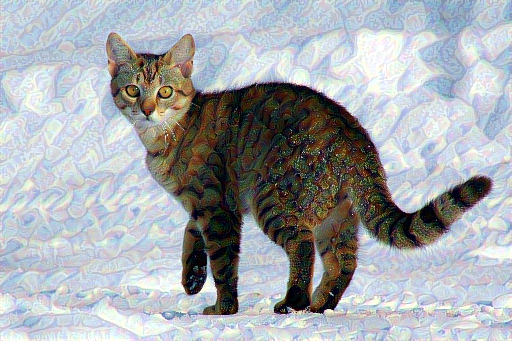

In [64]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

작동하므로 더 긴 최적화를 수행하십시오.

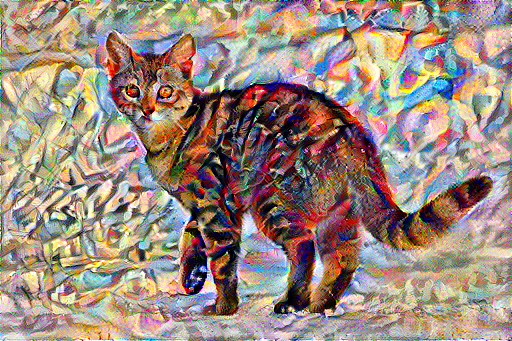

Train step: 1000
Total time: 71.0


In [65]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

### 총 변동 손실

이 기본 구현의 한 가지 단점은 많은 고주파 아티팩트를 생성한다는 것입니다. 이미지의 고주파수 구성 요소에 대한 명시 적 정규화 용어를 사용하여 이러한 값을 줄입니다. 스타일 전송에서는이를 종종 *총 변동 손실*이라고합니다.

In [66]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

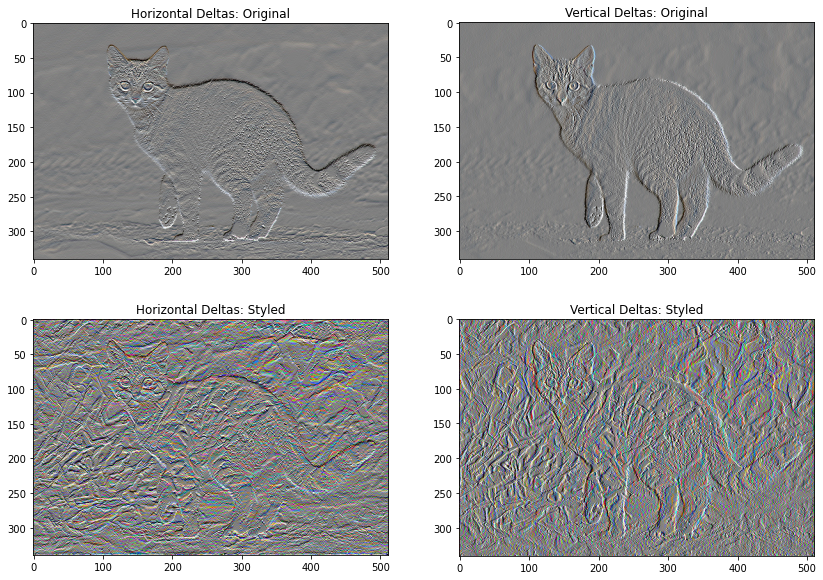

In [67]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

이것은 고주파 성분이 어떻게 증가했는지 보여줍니다.

또한,이 고주파 성분은 기본적으로 에지 검출기입니다. Sobel 에지 감지기에서 유사한 출력을 얻을 수 있습니다. 예를 들면 다음과 같습니다.

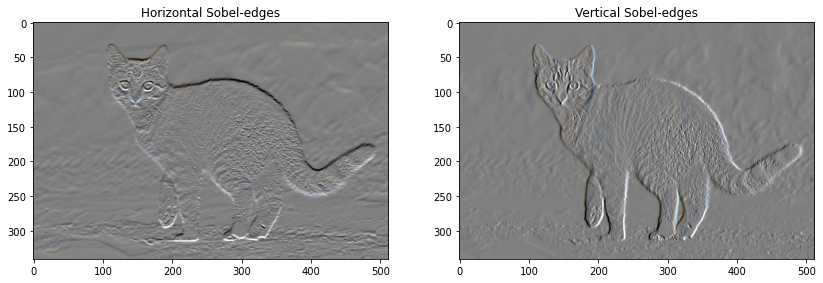

In [68]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

이와 관련된 정규화 손실은 값의 제곱의 합입니다. :

In [69]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [70]:
total_variation_loss(image).numpy()

114114.75

그것은 그것이 무엇을하는지 보여주었습니다. 하지만 직접 구현할 필요는 없습니다. TensorFlow에는 표준 구현이 포함되어 있습니다.

In [71]:
tf.image.total_variation(image).numpy()

array([114114.75], dtype=float32)

## 최적화를 다시 실행하십시오.

'total_variation_loss'에 대한 가중치를 선택합니다.

In [72]:
total_variation_weight=30

이제`train_step` 함수에 포함합니다.

In [73]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

최적화 변수를 다시 초기화합니다.

In [74]:
image = tf.Variable(content_image)

그리고 최적화를 실행하십시오.

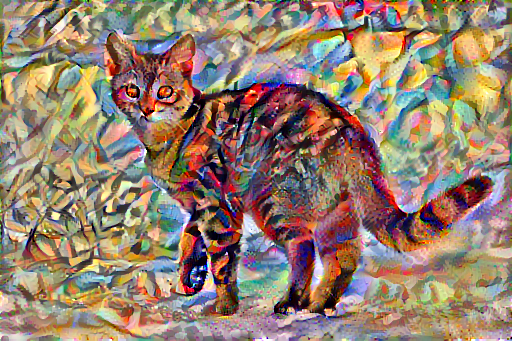

Train step: 1000
Total time: 71.9


In [75]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

마지막으로, *결과*를 저장합니다.

In [76]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>